# Problem: Car insurance fraud detection

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, recall_score, precision_recall_curve

## 1. Aims, objectives, and plan

**AIM**

Build two models capable to predict fraudulent claims for a car insurance company and evaluate the cost of the best model based on its error and the company requirements. 

**OBJECTIVES**

1. Analyse a historic dataset provided by the company that comprises information regarding its customers and whether their claims were fraudulent or not. 
2. Build two models capable of predicting future fraudulent claims based on the information provided regarding previous customers. 
3. Provide the company with a pricing scheme based on the best model considering the following:
    - all valid claims that my model predicts to be fraudulent (false positives) result in customer loss,
    - all fraudulent cases that my model fails to flag (false negatives) correspond to unnecessary expenses,
    - the gross profit must amount to double the claims.
4. Estimate the cost of my model based on its error and the above assumptions/requirements.

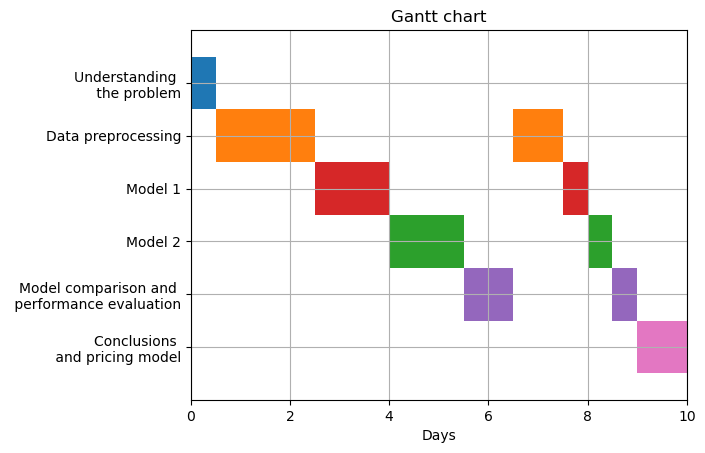

In [2]:
fig, gnt = plt.subplots()

gnt.set_ylim(0, 70)
gnt.set_xlim(0, 10)

gnt.set_title('Gantt chart')

gnt.set_xlabel('Days')
#gnt.set_ylabel('Task')

gnt.set_yticks([10, 20, 30, 40, 50, 60])

gnt.set_yticklabels(['Conclusions \n and pricing model', 'Model comparison and \n performance evaluation', 'Model 2', 'Model 1', 'Data preprocessing', 'Understanding \n the problem'])

gnt.grid(True)

gnt.broken_barh([(0, 0.5)], (55, 10), facecolors ='tab:blue')
gnt.broken_barh([(0.5, 2), (6.5, 1)], (45, 10), facecolors =('tab:orange'))
gnt.broken_barh([(2.5, 1.5), (7.5, 0.5)], (35, 10), facecolors =('tab:red'))
gnt.broken_barh([(4, 1.5), (8, 0.5)], (25, 10), facecolors =('tab:green'))
gnt.broken_barh([(5.5, 1), (8.5, 0.5)], (15, 10), facecolors =('tab:purple'))
gnt.broken_barh([(9, 1)], (5, 10), facecolors =('tab:pink'))

## 2. Understanding the case study

1. The problem is a binary classification problem with numerous features and a slight class imbalance. I will build two classification models (random forests (RF) and multilayer perceptron (MLP)) that can deal with this degree of complexity and handle well the class imbalance.

2. With this large number of features (especially after encoding), overfitting can be a problem. I will ensure the models do not overfit the data by choosing suitable hyperparameters based on the model performance on the training/test sets. 

3. I will find the best model based on nested cross-validation scores.

4. The company is interested in flagging fraudulent cases and minimize the number of customers lost. I will use a performance evaluation metric (macro recall) that gives importance to both aspects.

5. The company wants a pricing model. I will provide such pricing model based on my predictions and their errors. 

## 3. Pre-processing
This is only part of the preprocessing. 

I will perform imputation, encoding, and scaling later after train/test split as part of pipelines to avid data leakage. 

### 3.1 Pivoting and merging
- I inspect all dataframes to see how to best combine them.

- The vehicle dataframe has more entries than the others, but the number of unique CustomerIDs is the same. I pivot this dataframe.

- After checking that the CustomerIDs are the same, I merge the dataframes into one, called df.

In [3]:
#importing the various data into corresponding dataframes
claim = pd.read_csv('TrainData/Train_Claim.csv')
demo = pd.read_csv('TrainData/Train_Demographics.csv')
policy = pd.read_csv('TrainData/Train_Policy.csv')
vehicle = pd.read_csv('TrainData/Train_Vehicle.csv')
target = pd.read_csv('TrainData/Traindata_with_Target.csv')

In [4]:
#I check the dataframes to see how to best combine them
print(claim.shape)
claim.head()

(28836, 19)


,CustomerID,DateOfIncident,TypeOfIncident,TypeOfCollission,SeverityOfIncident,AuthoritiesContacted,IncidentState,IncidentCity,IncidentAddress,IncidentTime,NumberOfVehicles,PropertyDamage,BodilyInjuries,Witnesses,PoliceReport,AmountOfTotalClaim,AmountOfInjuryClaim,AmountOfPropertyClaim,AmountOfVehicleDamage
0,Cust10000,2015-02-03,Multi-vehicle Collision,Side Collision,Total Loss,Police,State7,City1,Location 1311,17,3,?,1,0,?,65501,13417,6071,46013
1,Cust10001,2015-02-02,Multi-vehicle Collision,Side Collision,Total Loss,Police,State7,City5,Location 1311,10,3,YES,2,1,YES,61382,15560,5919,39903
2,Cust10002,2015-01-15,Single Vehicle Collision,Side Collision,Minor Damage,Other,State8,City6,Location 2081,22,1,YES,2,3,NO,66755,11630,11630,43495
3,Cust10003,2015-01-19,Single Vehicle Collision,Side Collision,Minor Damage,Other,State9,City6,Location 2081,22,1,YES,2,3,NO,66243,12003,12003,42237
4,Cust10004,2015-01-09,Single Vehicle Collision,Rear Collision,Minor Damage,Fire,State8,City6,Location 1695,10,1,NO,2,1,YES,53544,8829,7234,37481


In [5]:
print(demo.shape)
demo.head()

(28836, 10)


,CustomerID,InsuredAge,InsuredZipCode,InsuredGender,InsuredEducationLevel,InsuredOccupation,InsuredHobbies,CapitalGains,CapitalLoss,Country
0,Cust10000,35,454776,MALE,JD,armed-forces,movies,56700,-48500,India
1,Cust10001,36,454776,MALE,JD,tech-support,cross-fit,70600,-48500,India
2,Cust10002,33,603260,MALE,JD,armed-forces,polo,66400,-63700,India
3,Cust10003,36,474848,MALE,JD,armed-forces,polo,47900,-73400,India
4,Cust10004,29,457942,FEMALE,High School,exec-managerial,dancing,0,-41500,India


In [6]:
print(policy.shape)
policy.head()

(28836, 10)


,InsurancePolicyNumber,CustomerLoyaltyPeriod,DateOfPolicyCoverage,InsurancePolicyState,Policy_CombinedSingleLimit,Policy_Deductible,PolicyAnnualPremium,UmbrellaLimit,InsuredRelationship,CustomerID
0,110122,328,2014-10-17,State3,250/500,1000,1406.91,0,husband,Cust1001
1,110125,256,1990-05-25,State1,250/500,2000,1415.74,6000000,unmarried,Cust1004
2,110126,228,2014-06-06,State1,500/1000,1000,1583.91,6000000,unmarried,Cust1005
3,110127,256,2006-10-12,State3,250/500,1000,1351.10,0,unmarried,Cust1006
4,110128,137,2000-06-04,State2,250/500,1000,1333.35,0,husband,Cust1007


In [7]:
#this dataframe has more entries than the others
print(vehicle.shape)
vehicle.head()

(115344, 3)


,CustomerID,VehicleAttribute,VehicleAttributeDetails
0,Cust20179,VehicleID,Vehicle8898
1,Cust21384,VehicleModel,Malibu
2,Cust33335,VehicleMake,Toyota
3,Cust27118,VehicleModel,Neon
4,Cust13038,VehicleID,Vehicle30212


In [8]:
#but the number of unique CustomerID values is the same
print(len(vehicle.CustomerID.unique()))

28836


In [9]:
print(target.shape)
target.head()

(28836, 2)


,CustomerID,ReportedFraud
0,Cust20065,N
1,Cust37589,N
2,Cust24312,N
3,Cust5493,Y
4,Cust7704,Y


In [10]:
#I check if the records for the CustomerID column are the same in all dataframes. I use sets to do this.
set1 = set(claim.CustomerID)
set2 = set(demo.CustomerID)
set3 = set(policy.CustomerID)
set4 = set(vehicle.CustomerID)
set5 = set(target.CustomerID)

print('Number of CustomerID values in claim:', len(set1))
print('Number of CustomerID values in demo:', len(set2))
print('Number of CustomerID values in policy:', len(set3))
print('Number of CustomerID values in vehicle:', len(set4))
print('Number of CustomerID values in target:', len(set5))
print('Number of CustomerID values in the intersection of the five dataframes:', len(set1 & set2 & set3 & set4 & set5))
#This proves that the Customer ID values are the same in all dataframes

Number of CustomerID values in claim: 28836
Number of CustomerID values in demo: 28836
Number of CustomerID values in policy: 28836
Number of CustomerID values in vehicle: 28836
Number of CustomerID values in target: 28836
Number of CustomerID values in the intersection of the five dataframes: 28836


In [11]:
#I pivot the vehcicle dataframe
vehicle_pivoted = vehicle.pivot(index='CustomerID', columns='VehicleAttribute', values='VehicleAttributeDetails').reset_index()
print(vehicle_pivoted.shape)
vehicle_pivoted.head()

(28836, 5)


VehicleAttribute,CustomerID,VehicleID,VehicleMake,VehicleModel,VehicleYOM
0,Cust10000,Vehicle26917,Audi,A5,2008
1,Cust10001,Vehicle15893,Audi,A5,2006
2,Cust10002,Vehicle5152,Volkswagen,Jetta,1999
3,Cust10003,Vehicle37363,Volkswagen,Jetta,2003
4,Cust10004,Vehicle28633,Toyota,CRV,2010


In [12]:
#I merge the five dataframes into one.
claim_demo = pd.merge(claim, demo, on='CustomerID')
claim_demo_policy = pd.merge(claim_demo, policy, on='CustomerID')
claim_demo_policy_vehicle = pd.merge(claim_demo_policy, vehicle_pivoted, on='CustomerID')

#My final dataframe, which I call df 
df = pd.merge(claim_demo_policy_vehicle, target, on='CustomerID')

df_original = df.copy()

df.head()

,CustomerID,DateOfIncident,TypeOfIncident,TypeOfCollission,SeverityOfIncident,AuthoritiesContacted,IncidentState,IncidentCity,IncidentAddress,IncidentTime,...,Policy_CombinedSingleLimit,Policy_Deductible,PolicyAnnualPremium,UmbrellaLimit,InsuredRelationship,VehicleID,VehicleMake,VehicleModel,VehicleYOM,ReportedFraud
0,Cust10000,2015-02-03,Multi-vehicle Collision,Side Collision,Total Loss,Police,State7,City1,Location 1311,17,...,100/300,1000,1632.73,0,not-in-family,Vehicle26917,Audi,A5,2008,N
1,Cust10001,2015-02-02,Multi-vehicle Collision,Side Collision,Total Loss,Police,State7,City5,Location 1311,10,...,100/300,1000,1255.19,0,not-in-family,Vehicle15893,Audi,A5,2006,N
2,Cust10002,2015-01-15,Single Vehicle Collision,Side Collision,Minor Damage,Other,State8,City6,Location 2081,22,...,500/1000,617,1373.38,0,wife,Vehicle5152,Volkswagen,Jetta,1999,N
3,Cust10003,2015-01-19,Single Vehicle Collision,Side Collision,Minor Damage,Other,State9,City6,Location 2081,22,...,500/1000,722,1337.60,0,own-child,Vehicle37363,Volkswagen,Jetta,2003,N
4,Cust10004,2015-01-09,Single Vehicle Collision,Rear Collision,Minor Damage,Fire,State8,City6,Location 1695,10,...,100/300,500,1353.73,4279863,unmarried,Vehicle28633,Toyota,CRV,2010,N


### 3.2 Dealing with duplicates
There are no duplicate rows (nor Customer IDs) in the df.

In [13]:
num_duplicates = df.duplicated().sum()
print('There are', num_duplicates, 'duplicate rows in the df')

There are 0 duplicate rows in the df


### 3.3 Dealing with missing values
- I replace all formats of missing values with NaN.

- I notice that 'PropertyDamage' and 'PoliceReport' have more than 1/3 of missing values and their NO/YES counts are rather balanced, so imputing the missing values with the mode could bias the model. I thus create a separate category for missing values for these features.

- I will deal with the NaN values in pipelines later.

In [14]:
missing_values = ['NA', -1, 'MISSINGVAL', '?', -5, 'MISSINGVALUE', 'MISSEDDATA', '???']
df.replace(missing_values, np.nan, inplace=True)

In [15]:
#I check for possible other formats in which the missing values may have been written 
#It seems there are no more formats
for column in df.columns:
    print(f'Unique values in {column}:')
    print(df[column].unique())
    print()

Unique values in CustomerID:
['Cust10000' 'Cust10001' 'Cust10002' ... 'Cust9996' 'Cust9997' 'Cust9999']

Unique values in DateOfIncident:
['2015-02-03' '2015-02-02' '2015-01-15' '2015-01-19' '2015-01-09'
 '2015-02-07' '2015-01-30' '2015-01-12' '2015-02-06' '2015-01-25'
 '2015-02-10' '2015-02-22' '2015-02-25' '2015-01-02' '2015-02-28'
 '2015-01-03' '2015-01-29' '2015-02-23' '2015-01-28' '2015-02-26'
 '2015-01-27' '2015-01-16' '2015-01-17' '2015-02-04' '2015-01-05'
 '2015-01-10' '2015-02-11' '2015-01-13' '2015-01-06' '2015-01-07'
 '2015-02-17' '2015-02-12' '2015-02-13' '2015-01-26' '2015-02-21'
 '2015-02-14' '2015-02-15' '2015-01-20' '2015-01-24' '2015-01-08'
 '2015-01-11' '2015-02-09' '2015-02-27' '2015-02-24' '2015-01-18'
 '2015-02-08' '2015-01-22' '2015-02-19' '2015-02-18' '2015-02-16'
 '2015-01-04' '2015-02-05' '2015-01-01' '2015-01-23' '2015-01-21'
 '2015-01-14' '2015-02-20' '2015-01-31' '2015-03-06' '2015-03-01'
 '2015-03-04' '2015-03-03' '2015-03-02' '2015-02-01' '2015-03-05'
 '20

In [16]:
#These are all the NaN values per feature
df.isna().sum()

CustomerID                        0
DateOfIncident                    0
TypeOfIncident                    0
TypeOfCollission               5162
SeverityOfIncident                0
AuthoritiesContacted           2692
IncidentState                     0
IncidentCity                      0
IncidentAddress                   0
IncidentTime                     31
NumberOfVehicles                  0
PropertyDamage                10459
BodilyInjuries                    0
Witnesses                        46
PoliceReport                   9805
AmountOfTotalClaim               50
AmountOfInjuryClaim               0
AmountOfPropertyClaim             0
AmountOfVehicleDamage             0
InsuredAge                        0
InsuredZipCode                    0
InsuredGender                    30
InsuredEducationLevel             0
InsuredOccupation                 0
InsuredHobbies                    0
CapitalGains                      0
CapitalLoss                       0
Country                     

In [17]:
#PropertyDamage and PoliceReport have more than 1/3 of missing values. 
#The NO/YES counts are rather balanced (see below). 
#Imputing the missing values with the mode could bias the model. 
df.PropertyDamage.value_counts()

PropertyDamage
NO     9687
YES    8690
Name: count, dtype: int64

In [18]:
df.PoliceReport.value_counts()

PoliceReport
NO     9898
YES    9133
Name: count, dtype: int64

In [19]:
#For these two features, I create a separate category for missing values. 
#When I will later encode these features, I will have three categories: YES, NO, and missing. 
df['PropertyDamage_filled'] = df['PropertyDamage'].fillna('missing')
df['PoliceReport_filled'] = df['PoliceReport'].fillna('missing')

#I drop the original columns
df.drop(['PropertyDamage', 'PoliceReport'], axis=1, inplace=True)

### 3.4 Dealing with wrong dtypes
Some features have dtype object, but should be converted to numeric

In [20]:
features_to_convert = ['Witnesses', 'AmountOfTotalClaim', 'VehicleYOM']
for feature in features_to_convert:
    df[feature] = pd.to_numeric(df[feature], errors='coerce').astype(float)
    
print(df[features_to_convert].dtypes)

Witnesses             float64
AmountOfTotalClaim    float64
VehicleYOM            float64
dtype: object


### 3.5 Preparing the label
The label is binary and of type object. I convert it to numeric. There are no missing values in the label. 

In [21]:
print('The original label ReportedFraud is of type', df.ReportedFraud.dtype)

#Conversion
df.ReportedFraud.replace({'N': 0, 'Y': 1}, inplace=True)

print('The converted label ReportedFraud is of type', df.ReportedFraud.dtype)

The original label ReportedFraud is of type object
The converted label ReportedFraud is of type int64


### 3.6 Feature extraction and filtering
- From 'DateOfIncident' and 'DateOfPolicyCoverage', I extract two more meaningful features: 'MonthOfIncident' and 'DaysFromPolicyStartToIncident'. There are no missing values in these two features.

- There are two negative values in 'DaysFromPolicyStartToIncident': I filter the corresponding rows. 

In [22]:
#I check that all dates are in the same format yyyy-mm-dd
parsed_DateOfIncident = pd.to_datetime(df.DateOfIncident, errors='coerce')
parsed_DateOfPolicyCoverage = pd.to_datetime(df.DateOfPolicyCoverage, errors='coerce')

print('Number of rows in DateOfIncident with incorrect format:', parsed_DateOfIncident.isna().sum()) 
print('Number of rows in DateOfPolicyCoverage with incorrect format:', parsed_DateOfPolicyCoverage.isna().sum())

Number of rows in DateOfIncident with incorrect format: 0
Number of rows in DateOfPolicyCoverage with incorrect format: 0


In [23]:
#extracting the month from DateOfIncident
df['MonthOfIncident'] = parsed_DateOfIncident.dt.month

In [24]:
#extracting the number of days elapsed from the start of the policy to the incident date
df['DaysFromPolicyStartToIncident'] = (parsed_DateOfIncident - parsed_DateOfPolicyCoverage).dt.days

#check if there are some negative values in DaysFromPolicyStartToIncident, which would not make sense
num_negatives = (df['DaysFromPolicyStartToIncident'] < 0).sum()
print('Number of negative values for DaysFromPolicyStartToIncident', num_negatives)

#I filter these two records
df = df[df['DaysFromPolicyStartToIncident'] >= 0]
num_negatives = (df['DaysFromPolicyStartToIncident'] < 0).sum()
print('Number of negative values for DaysFromPolicyStartToIncident', num_negatives)

Number of negative values for DaysFromPolicyStartToIncident 2
Number of negative values for DaysFromPolicyStartToIncident 0


In [25]:
#I drop the features DateOfIncident and DateOfPolicyCoverage
df.drop(['DateOfIncident', 'DateOfPolicyCoverage'], axis=1, inplace=True)

### 3.7 Initial feature selection
- I drop 'CustomerID', Country (it is always India), 'InsurancePolicyNumber', and 'VehicleID' as they do not contain useful information. 

- I drop 'IncidentAddress' (too large cardinality for OH encoding), I keep 'VehicleModel' as removing it reduces the performance of both models, but I will drop 'InsuredHobbies' for RF as it improves its performance.

- I will perform more advanced feature selection after train/test splitting to avoid data leakage.  

In [26]:
df_categorical = df.select_dtypes(include='object')
cardinalities = df_categorical.nunique()
print(cardinalities.sort_values(ascending=False))

CustomerID                    28834
VehicleID                     28834
IncidentAddress                1000
VehicleModel                     39
InsuredHobbies                   20
VehicleMake                      14
InsuredOccupation                14
Policy_CombinedSingleLimit        9
IncidentCity                      7
InsuredEducationLevel             7
IncidentState                     7
InsuredRelationship               6
TypeOfIncident                    4
AuthoritiesContacted              4
SeverityOfIncident                4
InsurancePolicyState              3
TypeOfCollission                  3
PropertyDamage_filled             3
PoliceReport_filled               3
InsuredGender                     2
Country                           1
dtype: int64


In [27]:
df.drop(['CustomerID', 'Country', 'InsurancePolicyNumber', 'VehicleID', 'IncidentAddress'], axis=1, inplace=True)
df.head()

,TypeOfIncident,TypeOfCollission,SeverityOfIncident,AuthoritiesContacted,IncidentState,IncidentCity,IncidentTime,NumberOfVehicles,BodilyInjuries,Witnesses,...,UmbrellaLimit,InsuredRelationship,VehicleMake,VehicleModel,VehicleYOM,ReportedFraud,PropertyDamage_filled,PoliceReport_filled,MonthOfIncident,DaysFromPolicyStartToIncident
0,Multi-vehicle Collision,Side Collision,Total Loss,Police,State7,City1,17.0,3,1,0.0,...,0,not-in-family,Audi,A5,2008.0,0,missing,missing,2,5945
1,Multi-vehicle Collision,Side Collision,Total Loss,Police,State7,City5,10.0,3,2,1.0,...,0,not-in-family,Audi,A5,2006.0,0,YES,YES,2,5192
2,Single Vehicle Collision,Side Collision,Minor Damage,Other,State8,City6,22.0,1,2,3.0,...,0,wife,Volkswagen,Jetta,1999.0,0,YES,NO,1,5085
3,Single Vehicle Collision,Side Collision,Minor Damage,Other,State9,City6,22.0,1,2,3.0,...,0,own-child,Volkswagen,Jetta,2003.0,0,YES,NO,1,3570
4,Single Vehicle Collision,Rear Collision,Minor Damage,Fire,State8,City6,10.0,1,2,1.0,...,4279863,unmarried,Toyota,CRV,2010.0,0,NO,YES,1,6650


### 3.8 Identifying and dealing with class imbalance
There is a mild class imbalance: 73% vs 27%. I will deal with it using:
- stratified test/train split, 
- cross validation with StratifiedKFold,
- adding class_weight='balanced' to RF,
- considering suitable evaluation metrics.

In [28]:
df.ReportedFraud.value_counts(normalize=True)

ReportedFraud
0    0.730006
1    0.269994
Name: proportion, dtype: float64

### 3.9 Defining X/y and train/test split

In [29]:
X = df.drop('ReportedFraud', axis=1)
y = df.ReportedFraud

# Train/test split with stratification to account for class imbalance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

### 3.10 Feature selection based on Pearson correlation
I find two pairs of features that are strongly correlated (correlation coefficient > 0.9). However, removing one or both decreases the performance of RF, while removing 'AmountOfVehicleDamage' improves the performance of MLP. I will do it later.

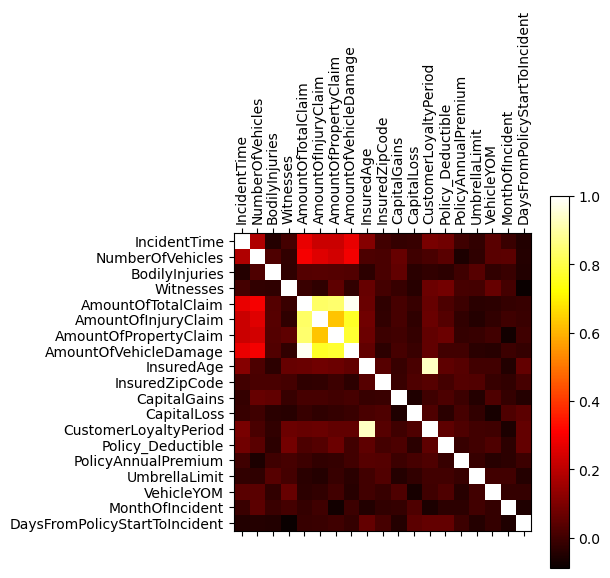

In [30]:
#function to plot the Pearson correlation betwen numerical features
def correlation(dataframe):
    dataframe = dataframe.select_dtypes(include='number')
    plt.matshow(dataframe.corr(), cmap=plt.get_cmap('hot'))
    plt.colorbar()
    name_rng = np.arange(0,dataframe.columns.size)
    plt.xticks(name_rng, dataframe.columns, rotation=90)
    plt.yticks(name_rng, dataframe.columns)
    plt.show()
 
correlation(X_train)

In [31]:
#two pairs of features are strongly correlated (correlation coefficient > 0.9)
X_train[['CustomerLoyaltyPeriod', 'InsuredAge', 'AmountOfVehicleDamage', 'AmountOfTotalClaim']].corr()

,CustomerLoyaltyPeriod,InsuredAge,AmountOfVehicleDamage,AmountOfTotalClaim
CustomerLoyaltyPeriod,1.000000,0.933307,0.055314,0.060812
InsuredAge,0.933307,1.000000,0.056163,0.066652
AmountOfVehicleDamage,0.055314,0.056163,1.000000,0.986560
AmountOfTotalClaim,0.060812,0.066652,0.986560,1.000000


### 3.11 Feature selection based on variance analysis
I check the variances of the numerical features. Even removing 'MonthOfIncident' (lowest variance) decreases the performance of both models. Thus, I do not remove any features based on variance.

In [32]:
X_train_num = X_train.select_dtypes(include='number')
variances = X_train_num.var()
print(variances.sort_values())

MonthOfIncident                  2.655069e-01
BodilyInjuries                   6.154883e-01
NumberOfVehicles                 9.613446e-01
Witnesses                        1.086296e+00
VehicleYOM                       2.816362e+01
IncidentTime                     3.768024e+01
InsuredAge                       6.438026e+01
CustomerLoyaltyPeriod            1.006968e+04
PolicyAnnualPremium              4.258062e+04
Policy_Deductible                2.985428e+05
DaysFromPolicyStartToIncident    5.724541e+06
AmountOfPropertyClaim            1.915453e+07
AmountOfInjuryClaim              1.974845e+07
AmountOfVehicleDamage            3.255772e+08
AmountOfTotalClaim               6.344653e+08
CapitalGains                     7.626071e+08
CapitalLoss                      7.827313e+08
InsuredZipCode                   5.229009e+09
UmbrellaLimit                    3.875636e+12
dtype: float64


### 3.12 Further feature selection
I tried to perform feature selection using SelectKBest with 'mutual_info_classif' (using different k values) inside the model pipelines to find the features that yield more information about the target, but I could not improve the performance of either model. As such, the code has been commented out.  

## 4. Technique 1: Random forests (RF)

### 4.1 Motivation and plan

**MOTIVATION**

I choose RF because it is: 
   - capable of dealing with continuous and categorical features (after suitable encoding),
   - capable of handling well irrelevant and redundant features, 
   - suitable for imbalanced datasets (if proper measures are adopted),
   - robust against overfitting (with proper hyperparameter tuning),
   - good at capturing complex feature interactions.    
    
**PLAN**

1. Preliminary steps
2. Set hyperparameters
3. Optimize the hyperparameters
4. Fit the model
5. Evaluate the model

### 4.2 Preliminary steps
- Drop 'InsuredHobbies' based on Section 3.7,
- Differentiate between features,
- Feature preprocessing using pipelines,
- Final pipeline, which includes preprocessing and RF model.

In [33]:
X_train_rf = X_train.drop(['InsuredHobbies'], axis=1)
X_test_rf = X_test.drop(['InsuredHobbies'], axis=1)

In [34]:
#I differentiate between numerical, ordinal, and nominal features for treating missingness and encoding
numerical_feat_rf = X_train_rf.select_dtypes(include='number').columns.tolist()

nominal_feat_rf = ['TypeOfIncident', 'TypeOfCollission', 'AuthoritiesContacted', 'IncidentState', 'IncidentCity', 
                'InsuredGender', 'InsuredOccupation', 'InsurancePolicyState', 'Policy_CombinedSingleLimit', 
                'InsuredRelationship', 'VehicleMake', 'VehicleModel', 'PropertyDamage_filled', 'PoliceReport_filled']

ordinal_feat_rf = ['SeverityOfIncident', 'InsuredEducationLevel']

#Defining the order in which I want the ordinal features to be encoded
SeverityOfIncident_categories = ['Trivial Damage', 'Minor Damage', 'Major Damage', 'Total Loss']
InsuredEducationLevel_categories = ['High School', 'Associate', 'College', 'Masters', 'JD', 'MD', 'PhD']

#checking that I have got all the features
len(numerical_feat_rf) + len(nominal_feat_rf) + len(ordinal_feat_rf) == X_train_rf.shape[1]

True

In [35]:
# Preprocessing for numerical features: I impute missing values with the mean
numerical_preprocessor_rf = SimpleImputer(strategy='mean')

# Preprocessing for nominal features with a pipeline: I impute missing values with the mode and I encode with OH encoding
nominal_preprocessor_rf = Pipeline(steps=[
                        ('imputer', SimpleImputer(strategy='most_frequent')),
                        ('encoder', OneHotEncoder(sparse_output=False))
])

# Preprocessing for ordinal features with a pipeline: I impute missing values with the mode and I encode with ordinal encoding
ordinal_preprocessor_rf = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(categories=[SeverityOfIncident_categories, InsuredEducationLevel_categories]))
])

# Column transformer to appy different preprocessing steps to the different features
preprocessor_rf = ColumnTransformer(transformers=[
        ('num', numerical_preprocessor_rf, numerical_feat_rf),
        ('nom', nominal_preprocessor_rf, nominal_feat_rf),
        ('ord', ordinal_preprocessor_rf, ordinal_feat_rf),
])

#I check how many features I have after encoding
preprocessor_rf.fit(X_train_rf)
X_train_rf_transformed = preprocessor_rf.transform(X_train_rf)
print("Number of features after encoding:", X_train_rf_transformed.shape[1])

# Final pipeline that includes the RF model. I use class_weight='balanced' to account for class imbalance.
pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor_rf),
    #('feature_selection', SelectKBest(mutual_info_classif, k=140)),
    ('classifier', RandomForestClassifier(class_weight='balanced', random_state=0))
])

Number of features after encoding: 139


### 4.3 Setting the hyperparameters
I select the most important hyperparameters below. I keep max_depth low and min_samples_split/min_samples_leaf high to control overfitting. I do not explore too many values to keep the computational time reasonable.

In [36]:
parameters_rf = {
    'classifier__n_estimators': [100, 300, 500],
    'classifier__max_depth': [10, 20],
    'classifier__min_samples_split': [5, 10],  
    'classifier__min_samples_leaf': [5, 10] 
}

### 4.4  Optimising the hyperparameters
I use grid search with CV


In [37]:
#set CV
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=0)

#set grid serch
grid_search_rf = GridSearchCV(
    estimator=pipeline_rf,
    param_grid=parameters_rf,
    cv=cv,
    scoring='recall_macro',
    n_jobs=-1
)

### 4.5 Fitting the model
I fit the final model to the training set

In [38]:
%%time
#fit
grid_search_rf.fit(X_train_rf, y_train)

CPU times: total: 18.4 s
Wall time: 5min 8s


GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         SimpleImputer(),
                                                                         ['IncidentTime',
                                                                          'NumberOfVehicles',
                                                                          'BodilyInjuries',
                                                                          'Witnesses',
                                                                          'AmountOfTotalClaim',
                                                                          'AmountOfInjuryClaim',
                                                                          'AmountOfPropertyClaim',
                                                                          'AmountOfVehicleDamage',
                                                                          'InsuredAge',
                                                                          'InsuredZipCo...
                                                                                                                      'Masters',
                                                                                                                      'JD',
                                                                                                                      'MD',
                                                                                                                      'PhD']]))]),
                                                                         ['SeverityOfIncident',
                                                                          'InsuredEducationLevel'])])),
                                       ('classifier',
                                        RandomForestClassifier(class_weight='balanced',
                                                               random_state=0))]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': [10, 20],
                         'classifier__min_samples_leaf': [5, 10],
                         'classifier__min_samples_split': [5, 10],
                         'classifier__n_estimators': [100, 300, 500]},
             scoring='recall_macro')

### 4.6 Performance metrics (and checking for overfitting)
- I make predictions for the training/test sets,
- I calculate the macro recall for both sets,
- I print the best parameters, classification report, and confusion matrix.

Regarding overfitting, I compare the macro recall scores: 
- Training vs Test: (0.931-0.890)/0.931 = 0.044
- Training vs CV: (0.931-0.889)/0.931 = 0.045

The discrepancy is $\sim$4%, thus overfitting is under control with the selected hyperparameters, and the model can generalize well. 

The fact that the scores for the test/CV are very similar means that I am not overfitting the CV folds during hyperparameter tuning and that the distribution of the test set is consistent with that of the training set. 

In [39]:
%%time
#prediction for the training set
y_train_pred_rf = grid_search_rf.predict(X_train_rf)

#macro recall for the training set
train_macro_recall_rf = recall_score(y_train, y_train_pred_rf, average='macro')

#prediction for the test set
y_test_pred_rf = grid_search_rf.predict(X_test_rf)

#macro recall for the test set
test_macro_recall_rf = recall_score(y_test, y_test_pred_rf, average='macro')

print("Random forests:")
print("Macro recall for training set: %.3f" % train_macro_recall_rf)
print("Macro recall for test set: %.3f" % test_macro_recall_rf)
print("Macro recall over the 4 folds: %.3f" % grid_search_rf.best_score_)

Random forests:
Macro recall for training set: 0.931
Macro recall for test set: 0.890
Macro recall over the 4 folds: 0.889
CPU times: total: 2.05 s
Wall time: 2.07 s


In [40]:
#Best parameters
print("Best Parameters:", grid_search_rf.best_params_)

Best Parameters: {'classifier__max_depth': 20, 'classifier__min_samples_leaf': 5, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 300}


In [41]:
#Classification report
print("Performance on the test set for the random forest model:\n", classification_report(y_test, y_test_pred_rf, digits=3))

Performance on the test set for the random forest model:
               precision    recall  f1-score   support

           0      0.932     0.972     0.952      4210
           1      0.916     0.807     0.858      1557

    accuracy                          0.928      5767
   macro avg      0.924     0.890     0.905      5767
weighted avg      0.927     0.928     0.926      5767



Text(0.5, 1.0, 'Confusion matrix for the random forest model')

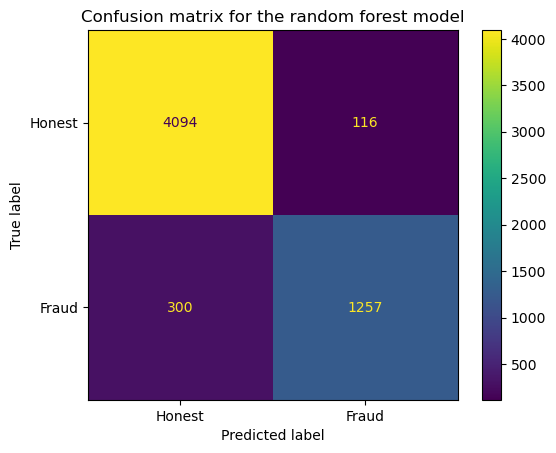

In [42]:
#Confusion matrix
cm_rf = confusion_matrix(y_test, y_test_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=['Honest', 'Fraud'])
disp.plot()
plt.title('Confusion matrix for the random forest model')

### 4.7 Dealing with class imbalance
The measures I have adopted:
- Train-test split with stratification,
- RandomForestClassifier with class_weight='balanced',
- Cross validation with StratifiedKFold,
- Suitable performance metric: scoring='recall_macro'.

## 5. Technique 2: Multilayer perceptron (MLP)

### 5.1 Motivation and plan

**MOTIVATION**

I choose MLP because it is:
   - capable of dealing with continuous and categorical features (after suitable scaling and encoding),
   - good at handling complex feature interactions (better than RF),
   - suitable for imbalanced datasets (but worse than RF),
   - capable of handling irrelevant and redundant features (but worse than RF),
   - rather robust against overfitting (with 'early_stopping=True' and suitable combinations of the regularization parameter $\alpha$ and learning rate).

**PLAN**

1. Preliminary steps
2. Set hyperparameters
3. Optimize the hyperparameters
4. Fit the model
5. Evaluate the model

### 5.2 Preliminary steps
- Drop 'AmountOfVehicleDamage' based on Section 3.10,
- Differentiate between features,
- Feature preprocessing using pipelines,
- Final pipeline, which includes preprocessing and MLP model.

In [43]:
X_train_mlp = X_train.drop(['AmountOfVehicleDamage'], axis=1)
X_test_mlp = X_test.drop(['AmountOfVehicleDamage'], axis=1)

In [44]:
#I differentiate between numerical, ordinal, and nominal features for treating missingness, encoding, and scaling
numerical_feat_mlp = X_train_mlp.select_dtypes(include='number').columns.tolist()

nominal_feat_mlp = ['TypeOfIncident', 'TypeOfCollission', 'AuthoritiesContacted', 'IncidentState', 'IncidentCity', 
                'InsuredGender', 'InsuredOccupation', 'InsurancePolicyState', 'Policy_CombinedSingleLimit', 
                'InsuredRelationship', 'VehicleMake', 'VehicleModel', 'PropertyDamage_filled', 'PoliceReport_filled', 
                'InsuredHobbies']

ordinal_feat_mlp = ['SeverityOfIncident', 'InsuredEducationLevel']

#Defining the order in which I want the ordinal features to be encoded
SeverityOfIncident_categories = ['Trivial Damage', 'Minor Damage', 'Major Damage', 'Total Loss']
InsuredEducationLevel_categories = ['High School', 'Associate', 'College', 'Masters', 'JD', 'MD', 'PhD']

#checking that I have got all the features
len(numerical_feat_mlp) + len(nominal_feat_mlp) + len(ordinal_feat_mlp) == X_train_mlp.shape[1]

True

In [45]:
# Peprocessing for numerical features with a pipeline: I impute missing values with the mean and perform scaling with StandardScaler
numerical_preprocessor_mlp = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Preprocessing for nominal features with a pipeline: I impute missing values with the mode and I encode with OH encoding
# This preprocessor is the same as that used for the previous technique.
nominal_preprocessor_mlp = Pipeline(steps=[
                        ('imputer', SimpleImputer(strategy='most_frequent')),
                        ('encoder', OneHotEncoder(sparse_output=False))
])

# Preprocessing for ordinal features with a pipeline: I impute missing values with the mode and I encode with ordinal encoding
# This preprocessor is the same as that used for the previous technique.
ordinal_preprocessor_mlp = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(categories=[SeverityOfIncident_categories, InsuredEducationLevel_categories]))
])

# Column transformer to appy different preprocessing steps to the different features
preprocessor_mlp = ColumnTransformer(transformers=[
        ('num', numerical_preprocessor_mlp, numerical_feat_mlp),
        ('nom', nominal_preprocessor_mlp, nominal_feat_mlp),
        ('ord', ordinal_preprocessor_mlp, ordinal_feat_mlp),
])

#I check how many features I have after encoding
preprocessor_mlp.fit(X_train_mlp)
X_train_mlp_transformed = preprocessor_mlp.transform(X_train_mlp)
print("Number of features after encoding:", X_train_mlp_transformed.shape[1])

# Final pipeline that includes the multilayer perceptron model. I set early_stopping = True to prevent overfitting
pipeline_mlp = Pipeline(steps=[
    ('preprocessor', preprocessor_mlp),
    #('feature_selection', SelectKBest(mutual_info_classif, k=140)),
    ('classifier', MLPClassifier(max_iter=1000, early_stopping=True, random_state=0))
])

Number of features after encoding: 158


### 5.3 Setting the hyperparameters
I select the most important hyperparameters below: 
   - I select 1, 2, and 3 hidden layers with different numbers of neurons,
   - I select different values for $\alpha$ and the learning rate. Depending on their values, one may encounter underfitting (e.g., high $\alpha$ and high learning rate) or overfitting/overshooting the minimum (e.g., low $\alpha$ and high learning rate).

I do not explore too many values to keep the computational time reasonable.

In [46]:
parameters_mlp = {
    'classifier__hidden_layer_sizes': [(50,), (100,), (100, 50), (100, 50, 30)], 
    'classifier__alpha': [0.01, 0.1, 1, 10], 
    'classifier__learning_rate_init': [0.001, 0.01, 0.1]
}

### 5.4  Optimising the hyperparameters
I use grid search with CV

In [47]:
#CV was set for the previous technique

#set grid serch
grid_search_mlp = GridSearchCV(
    estimator=pipeline_mlp,
    param_grid=parameters_mlp,
    cv=cv,
    scoring='recall_macro',  
    n_jobs=-1 
)

### 5.5 Fitting the model
I fit the final model to the training set

In [48]:
%%time
#fit
grid_search_mlp.fit(X_train_mlp, y_train)

CPU times: total: 16.6 s
Wall time: 4min 6s


GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['IncidentTime',
                                                                          'NumberOfVehicles',
                                                                          'BodilyInjuries',
                                                                          'Witnesses',
                                                                          'AmountOfTotalClaim',
                                                                          'AmountOfInjuryClaim',
                                                                          'AmountOfPropert...
                                                                                                                      'MD',
                                                                                                                      'PhD']]))]),
                                                                         ['SeverityOfIncident',
                                                                          'InsuredEducationLevel'])])),
                                       ('classifier',
                                        MLPClassifier(early_stopping=True,
                                                      max_iter=1000,
                                                      random_state=0))]),
             n_jobs=-1,
             param_grid={'classifier__alpha': [0.01, 0.1, 1, 10],
                         'classifier__hidden_layer_sizes': [(50,), (100,),
                                                            (100, 50),
                                                            (100, 50, 30)],
                         'classifier__learning_rate_init': [0.001, 0.01, 0.1]},
             scoring='recall_macro')

### 5.6 Performance metrics (and checking for overfitting)
- I make predictions for the training/test sets,
- I calculate the macro recall for both sets,
- I print the best parameters, classification report, and confusion matrix.

Regarding overfitting, I compare the macro recall scores: 
- Training vs Test: (0.919-0.883)/0.919 = 0.039
- Training vs cv: (0.919-0.866)/0.919 = 0.057

The discrepancy is $\sim$5%, thus overfitting is under control (but slightly worse than for RF), and the model can generalize well.  

The performance of RF is slightly better (not just the macro recall, but also the recall for class 1). I will check this also with nested CV in Section 6.

In [49]:
%%time
#prediction for the training set
y_train_pred_mlp = grid_search_mlp.predict(X_train_mlp)

#macro recall for the training set
train_macro_recall_mlp = recall_score(y_train, y_train_pred_mlp, average='macro')

#prediction for the test set
y_test_pred_mlp = grid_search_mlp.predict(X_test_mlp)

#macro recall for the test set
test_macro_recall_mlp = recall_score(y_test, y_test_pred_mlp, average='macro')

print("Multilayer perceptron:")
print("Macro recall for training set: %.3f" % train_macro_recall_mlp)
print("Macro recall for test set: %.3f" % test_macro_recall_mlp)
print("Macro recall over the 4 folds: %.3f" % grid_search_mlp.best_score_)

Multilayer perceptron:
Macro recall for training set: 0.919
Macro recall for test set: 0.883
Macro recall over the 4 folds: 0.866
CPU times: total: 172 ms
Wall time: 185 ms


In [50]:
#Best parameters
print("Best Parameters:", grid_search_mlp.best_params_)

Best Parameters: {'classifier__alpha': 0.1, 'classifier__hidden_layer_sizes': (100,), 'classifier__learning_rate_init': 0.001}


In [51]:
#Classification report
print("Performance on the test set for the multilayer perceptron model:\n", classification_report(y_test, y_test_pred_mlp, digits=3))

Performance on the test set for the multilayer perceptron model:
               precision    recall  f1-score   support

           0      0.929     0.964     0.946      4210
           1      0.892     0.801     0.844      1557

    accuracy                          0.920      5767
   macro avg      0.911     0.883     0.895      5767
weighted avg      0.919     0.920     0.919      5767



Text(0.5, 1.0, 'Confusion matrix for the multilayer perceptron model')

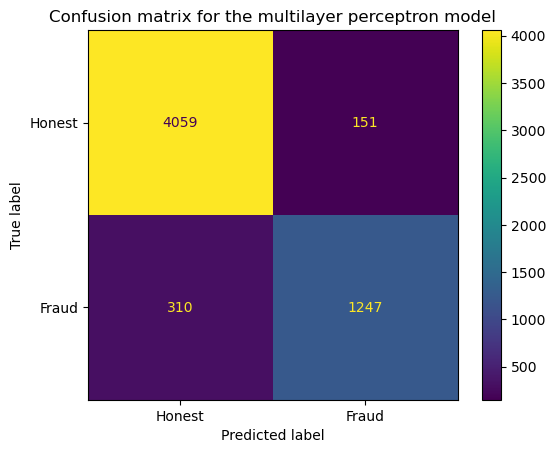

In [52]:
#Confusion matrix
cm_mlp = confusion_matrix(y_test, y_test_pred_mlp)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_mlp, display_labels=['Honest', 'Fraud'])
disp.plot()
plt.title('Confusion matrix for the multilayer perceptron model')

### 5.7 Dealing with class imbalance
The measures I have adopted:
- Train-test split with stratification,
- Cross validation with StratifiedKFold,
- Suitable performance metric: scoring='recall_macro'.

## 6. Performance comparison for the test set

### 6.1 Use of nested cross-validation

The macro recall obtained from nested CV for both models is very close to that obtained before (from gridsearchcv). I provide a summary table:

|  | RF | MLP |
| --- | --- | --- |
| Macro recall for training set | 0.931 | 0.919 |
| Macro recall for test set | 0.890 | 0.883 |
| Macro recall CV | 0.889 | 0.866 |
| Macro recall nested CV | 0.892 | 0.872|

I use these results to evaluate:

**1. OVERFITTING**

The fact that all the scores are close shows that overfitting is not a problem with the hyperparameters I selected. Furthermore, the fact that the std of the macro recall from nested CV is small for both models (0.004) is also a sign that the models are not overfitting.  

**2. MODEL COMPARISON**

RF performs consistently slightly better than MLP.

In [53]:
# I define the inner and outer cv loops
inner_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=0)
outer_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=0)

In [54]:
%%time
# Random forest inner loop (GridSearchCV)
nested_grid_search_rf = GridSearchCV(
    estimator=pipeline_rf,
    param_grid=parameters_rf,
    cv=inner_cv,
    scoring='recall_macro', 
    n_jobs=-1 
)

# Random forest outer loop (cross_val_score)
nested_scores_rf = cross_val_score(
    estimator=nested_grid_search_rf,
    X=X, #using the whole dataset
    y=y,
    cv=outer_cv,
    scoring='recall_macro',
    n_jobs=-1
)

print("Nested cv macro recall for the random forest model: %.3f ± %.3f" % (nested_scores_rf.mean(), nested_scores_rf.std()))

Nested cv macro recall for the random forest model: 0.892 ± 0.004
CPU times: total: 250 ms
Wall time: 19min 10s


In [55]:
%%time
# Multilayer perceptron inner loop (GridSearchCV)
nested_grid_search_mlp = GridSearchCV(
    estimator=pipeline_mlp,
    param_grid=parameters_mlp,
    cv=inner_cv,
    scoring='recall_macro',
    n_jobs=-1
)

# Multilayer perceptron outer loop (cross_val_score)
nested_scores_mlp = cross_val_score(
    estimator=nested_grid_search_mlp,
    X=X,
    y=y,
    cv=outer_cv,
    scoring='recall_macro',
    n_jobs=-1
)

print("Nested cv macro recall for the multilayer perceptron model: %.3f ± %.3f" % (nested_scores_mlp.mean(), nested_scores_mlp.std()))

Nested cv macro recall for the multilayer perceptron model: 0.872 ± 0.004
CPU times: total: 312 ms
Wall time: 32min 30s


### 6.2 Use appropriate metrics for the test set

False positives (FP) result in losing customers, while false negatives (FN) mean unnecessary costs. My metric should take into account both FP and FN cases. This is why I have chosen the balanced accuracy  (macro recall). However, the impact of FP on the pricing model (see next section) is much smaller than that of FN; thus, I check the PR curves for the RF model (see below). 

### 6.3 PR curves

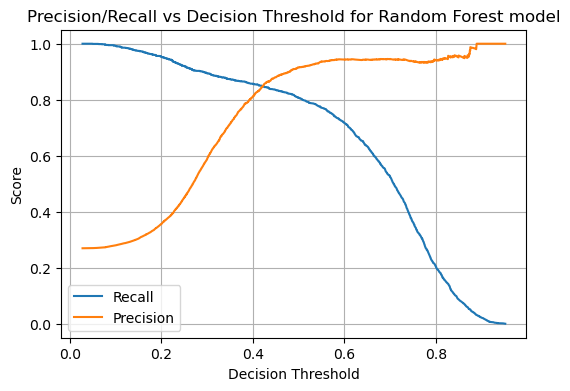

In [56]:
#get probability of positive class with rf model
y_test_proba = grid_search_rf.predict_proba(X_test_rf)[:, 1] 

#plot precision and recall as a function of decision threshold
prec, rec, thresh = precision_recall_curve(y_test, y_test_proba)

plt.figure(figsize=(6, 4))
plt.plot(thresh, rec[:-1], label='Recall')
plt.plot(thresh, prec[:-1], label='Precision')
plt.xlabel("Decision Threshold")
plt.ylabel("Score")
plt.title("Precision/Recall vs Decision Threshold for Random Forest model")
plt.legend()
plt.grid()
plt.show()

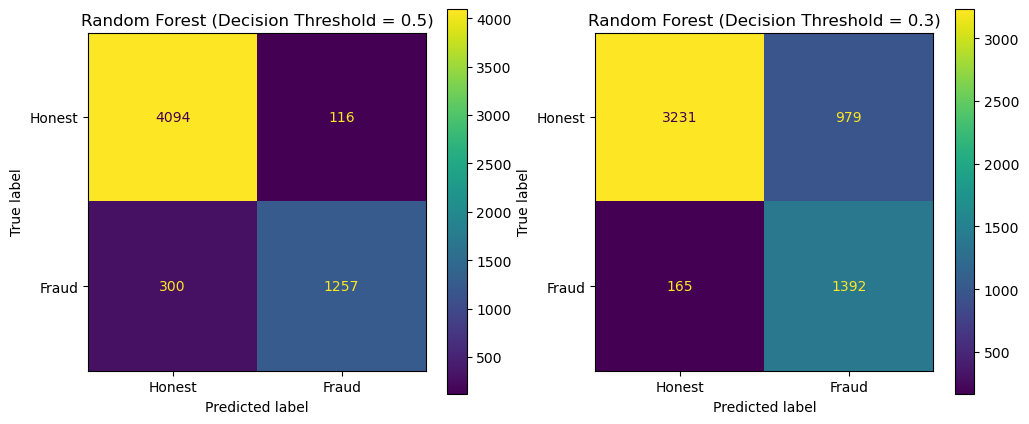

In [57]:
#I set the threshold to 0.3 to improve the recall for the positive class (at the expense of FP). The macro recall also decreases.
y_test_pred_thresh = (y_test_proba >=0.3).astype(int)

#New confusion matrix
new_cm_rf = confusion_matrix(y_test, y_test_pred_thresh)

#Compare the old and new confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

disp1 = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=['Honest', 'Fraud'])
disp1.plot(ax=axes[0])
axes[0].set_title('Random Forest (Decision Threshold = 0.5)')

disp2 = ConfusionMatrixDisplay(confusion_matrix=new_cm_rf, display_labels=['Honest', 'Fraud'])
disp2.plot(ax=axes[1])
axes[1].set_title('Random Forest (Decision Threshold = 0.3)')

plt.show()

In [58]:
#New classification report
print("Performance on the test set for the random forest model with decisoin threshold set to 0.3:\n", classification_report(y_test, y_test_pred_thresh, digits=3))

Performance on the test set for the random forest model with decisoin threshold set to 0.3:
               precision    recall  f1-score   support

           0      0.951     0.767     0.850      4210
           1      0.587     0.894     0.709      1557

    accuracy                          0.802      5767
   macro avg      0.769     0.831     0.779      5767
weighted avg      0.853     0.802     0.812      5767



### 6.4 Checking for overfitting
Done in section 6.1

## 7. Final recommendations

### 7.1 Technical perspective 

The best model is RF, which achieves a balanced accuracy (macro recall) of $89\%$, i.e. a balanced error rate of $11\%$.

**Overfitting**

With appropriate data preprocessing and hyperparameter tuning, RF exhibits small overfitting (difference $<5\%$ between training, test, and CV scores). This indicates that the model is stable and has good generalization performance.

**Complexity**

The model is rather complex (particularly with the high dimensionality introduced after OH encoding). While more extensive feature selection could simplify and improve the model, the current complexity does not seem to affect its generalization capacity.

**Efficiency**

The most time-consuming steps are hyperparameter tuning and performance evaluation, but after these steps and model training, the model is efficient at making predictions (2 sec on the test set). 

### 7.2 Business perspective
I consider three scenarios: 

1. The company does not apply any model, so it pays all claims. In this scenario, the revenue it aims to achieve (double the total claim amount) is at least 12,045,212,760 usd, while the income (total annual premiums) is only 363,830,187 usd. The company should increase their annual premium significantly to match their revenue threshold.

2. The company adopts my RF model with decision threshold = 0.5; it does not pay all claims (it does not pay the TP) but loses customers (FP). In this scenario, the required revenue is significantly lower (9,193,764,742 usd), while the income is only marginally lower (363,098,388 usd). The company should increase their annual premium by a smaller amount.

3. The company adopts my RF model with decision threshold = 0.3. The required revenue is 7,105,604,248 usd and the income is 357,654,057 usd. This comes at the cost of less accuracy and more lost customers, but from a financial perspective, this is the best scenario and it could improve further by lowering the decision threshold further.

The model thus improves the situation for the company.

I am puzzled by the disparity in cost and income; either the assumption of 10% of customers making a claim is not realistic or some numbers/units are wrong (average annual premium is only 1,261 usd, while average claim is 52,300 usd).

In [59]:
#extracting useful information from the df
tot_num_customers = df_original.shape[0]*10  #assuming the rate of claims in the customer base is 10%
ave_claim_amount = df['AmountOfTotalClaim'].mean()
tot_claim_amount = df['AmountOfTotalClaim'].sum()*4   #assuming the three months shown are representative for the year
ave_policy_premium = df['PolicyAnnualPremium'].mean()

#I multiply everything in the confusion matrix (with decision threshold = 0.5) by 5 (train/test = 80/20)
tp = 1257*5 #true positives
tn = 4094*5 #true negatives
fp = 116*5 #false positives
fn = 300*5 #false negatives

In [60]:
#Scenario with no model: the company pays every claim 
profit_threshold = 2 * tot_claim_amount  #this is the aim of the company 
income = tot_num_customers * ave_policy_premium

print('Scenario with no model:')
print('The aim of the company is to achive a profit of at least:' f'${profit_threshold:,.0f}') #assuming the currency is $
print('The income is:' f'${income:,.0f}')

Scenario with no model:
The aim of the company is to achive a profit of at least:$12,045,212,760
The income is:$363,830,187


In [61]:
#Scenario with RF model with decision threshold = 0.5: the company saves money by not paying the TP but loses customers (FP)
claim_amount_with_model = (tn + fn) * ave_claim_amount * 4  #assuming the three months shown are representative for the year
profit_threshold_with_model = 2 * claim_amount_with_model
income_with_model = (tot_num_customers - fp) * ave_policy_premium

print('Scenario with random forest model with decision threshold = 0.5:')
print('The aim of the company is to achive a profit of at least:' f'${profit_threshold_with_model:,.0f}')
print('The current income is:' f'${income_with_model:,.0f}')

Scenario with random forest model with decision threshold = 0.5:
The aim of the company is to achive a profit of at least:$9,193,764,742
The current income is:$363,098,388


In [62]:
#Scenario with RF model with decision threshold = 0.3: the company saves more money

#I multiply everything in the confusion matrix (with decision threshold = 0.3) by 3
tp = 1392*5 #true positives
tn = 3231*5 #true negatives
fp = 979*5 #false positives
fn = 165*5 #false negatives

claim_amount_with_revised_model = (tn + fn) * ave_claim_amount * 4  #assuming the three months shown are representative for the year
profit_threshold_with_revised_model = 2 * claim_amount_with_revised_model
income_with_revised_model = (tot_num_customers - fp) * ave_policy_premium

print('Scenario with random forest model with decision threshold = 0.3:')
print('The aim of the company is to achive a profit of at least:' f'${profit_threshold_with_revised_model:,.0f}')
print('The current income is:' f'${income_with_revised_model:,.0f}')

Scenario with random forest model with decision threshold = 0.3:
The aim of the company is to achive a profit of at least:$7,105,604,248
The current income is:$357,654,057


## 8. Conclusions

### 8.1 Accomplishments and failures
I built an RF model that has good generalization performance with a balanced error rate of 11%. I provided the company with a pricing model that would allow them to save 42% compared with the case in which they paid all claims. 

### 8.2 Reflections
Given more time, I would perform the following steps:
- Investigate the possible redundancy of categorical features (corr() applies just to numerical ones),
- Perform RFE/PCA to reduce dimensionality (especially for MLP), 
- Check if grouping categories for categorical features improves performance,
- Check if imputing missing values based on other attributes improves performance (e.g., missing values in 'PropertyDamage' could be imputed to YES if 'AmountOfTotalClaim' is high), 
- Apply SMOTE to MPL to better deal with class imbalance,
- Evaluate more hyperparameter values.

### 8.3 Wish list for future work
- Contact the company to ask them clarification regarding the 'ave_claim_amount' and if the assumption of 10% of customers making a claim is indeed realistic. 
- Check if there is a correspondence between the Indian festivities in the period investigated and the car accident dates.

## Acknowledgments
- Altahhan, A., 2025. [Lecture notes accessed through Minerva]. OCOM5101M Data Science. University of Leeds.
- Tan, P.-N., Steinbach, M. and Kumar, V., 2019. Introduction to Data Mining. 2nd ed. Harlow: Pearson.
- https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html
- https://scikit-learn.org/stable/auto_examples/model_selection/plot_nested_cross_validation_iris.html
- https://scikit-learn.org/stable/modules/compose.html
- https://scikit-learn.org/stable/modules/feature_selection.html
- https://www.kaggle.com/discussions/getting-started/564418
- https://scikit-learn.org/stable/common_pitfalls.html#data-leakage-during-pre-processing
- https://medium.com/@masadeghi6/how-to-split-your-data-for-machine-learning-eae893a8799c
- https://www.geeksforgeeks.org/python/python-basic-gantt-chart-using-matplotlib/
- https://www.kaggle.com/discussions/questions-and-answers/39659
- https://medium.com/@douglaspsteen/precision-recall-curves-d32e5b290248
- ChatGPT4, OpenAI, https://chat.openai.com, used for debugging my code.